In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Bootstrap Tutorial

This notebook contains a tutorial on how to use the bootstrap functionality provided by estimagic. In this example, we will work with the "exercise" example dataset taken from the seaborn library.

The working example will be a linear regression to investigate the effects of exercise time on pulse.

In [2]:
df = sns.load_dataset("exercise")
replacements = {"1 min": 1, "15 min": 15, "30 min": 30}
df = df.replace({"time": replacements})
df["constant"] = 1

df.head()

,Unnamed: 0,id,diet,pulse,time,kind,constant
0,0,1,low fat,85,1,rest,1
1,1,1,low fat,85,15,rest,1
2,2,1,low fat,88,30,rest,1
3,3,2,low fat,90,1,rest,1
4,4,2,low fat,92,15,rest,1


In general, there are two ways to use bootstrap functionality in estimagic. We can either use the main bootstrap() function, which will draw bootstrap samples, compute estimates, as well as compute standard errors and confidence intervals of these estimates at the same time. Or we can use the fact that all of the code is separated, and go through all of this step by step. 

In either way, the first thing that is required from the user is to specify a wrapping function that calculates the statistic of interest, and only takes the data on which to compute the statistic as an input. In our case, we want to regress "pulse" on "time" and a constant, and the function looks as follows:

In [3]:
def ols_fit(data):

    y = data["pulse"]
    x = data[["constant", "time"]]
    params = sm.OLS(y, x).fit().params
    return params

By returning a pd.Series with the coefficient names as index, we make sure we will eventually get a nice and readable output table. This is however not necessary. We could also simply return the parameter vector, in which case we would simply have to keep in mind the meaning of each parameter by ourselves.

## The Easy Way

After defining our function of interest, we can make use of estimagic's bootstrap functionality using one simple function call of the bootstrap() function.

In [4]:
from estimagic.inference.bootstrap import bootstrap

results_without_cluster = bootstrap(data=df, outcome=ols_fit)

results_without_cluster

,mean,std,lower_ci,upper_ci
constant,93.773208,1.554843,90.720816,96.737006
time,0.388344,0.124528,0.156922,0.644412


The above function call represents the minimum that a user has to specify, making full use of the default options, such as drawing a 1000 bootstrap draws, using the "percentile" bootstrap confidence interval, not making use of parallelization, etc.

If we would for example want to make 10000 draws, while parallelizing the maximum possible number of threads and using a "bca" type confidence interval, we would simply call the following.

In [5]:
results_without_cluster2 = bootstrap(
    data=df, outcome=ols_fit, n_draws=10_000, ci_method="bca", n_cores=-1
)

results_without_cluster2

,mean,std,lower_ci,upper_ci
constant,93.74677,1.513708,91.865431,97.372979
time,0.39163,0.126525,0.121384,0.556688


Estimagic implements two different types of bootstrap. In the standard bootstrap that we called in the two examples above, observations from the original dataset are drawn uniformly with replacement in order to create the different bootstrap samples.

In the cluster robust variant of the bootstrap, the original dataset is divided into clusters according to the values of some user-specified variable, and then clusters are drawn uniformly with replacement in order to create the different bootstrap samples. 

In order to use the cluster robust boostrap, we simply specify which variable to cluster by. In the example we are working with, it seems sensible to cluster on individuals, i.e. on the column "id" of our dataset.

In [6]:
results_with_cluster = bootstrap(data=df, outcome=ols_fit, cluster_by="id")

results_with_cluster

,mean,std,lower_ci,upper_ci
constant,93.797635,1.184685,91.531140,96.057505
time,0.386277,0.096167,0.216171,0.589993


We can see that the estimated standard errors are indeed of a smaller magnitude when we use the cluster robust bootstrap. 

Finally, we can compare the results to full sample regressions using the statsmodels regression function and see that the cluster robust bootstrap gives standard error estimates very close to the cluster robust regression, while the regular bootstrap seems to overestimate the standard errors of both coefficients.


In [7]:
y = df["pulse"]
x = df[["constant", "time"]]


cluster_robust_ols = sm.OLS(y, x).fit(cov_type="cluster", cov_kwds={"groups": df["id"]})

cluster_robust_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pulse   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     13.75
Date:                Mon, 28 Jun 2021   Prob (F-statistic):           0.000879
Time:                        13:56:21   Log-Likelihood:                -365.51
No. Observations:                  90   AIC:                             735.0
Df Residuals:                      88   BIC:                             740.0
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      93.7611      1.205     77.837      0.000      91.400      96.122
time           0.3873      0.104      3.708      0.000       0.183       0.592
==============================================================================
Omnibus:                       20.828   Durbin-Watson:                   0.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.313
Skew:                           1.173   Prob(JB):                     1.93e-06
Kurtosis:                       4.231   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## A Complete Separation of Code

There might of course also be situations where we simply want to return the collection of bootstrap estimates and not directly get the very streamlined results table. The following example makes use of the complete separation of code.

In [8]:
from estimagic.inference.bootstrap_helpers import get_seeds

more_seeds = get_seeds(2000)

Next, we can use get_bootstrap_estimates() to get the pd.DataFrame containing all of the different bootstrap estimates for f. We could again use cluster_by to use the clustered bootstrap.

In [9]:
from estimagic.inference.bootstrap_estimates import get_bootstrap_estimates

my_estimates = get_bootstrap_estimates(data=df, outcome=ols_fit, seeds=more_seeds)

print(my_estimates.head())

    constant      time
0  92.605956  0.414372
1  93.639486  0.434916
2  92.360304  0.616263
3  91.803283  0.661963
4  92.868684  0.307827


To further compare the cluster bootstrap to the uniform bootstrap, let's plot the sampling distribution of the parameters on time. We can again see that the standard error is smaller when we cluster on the subject id. 

/home/janos/anaconda3/envs/estimagic/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/janos/anaconda3/envs/estimagic/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time', ylabel='Density'>

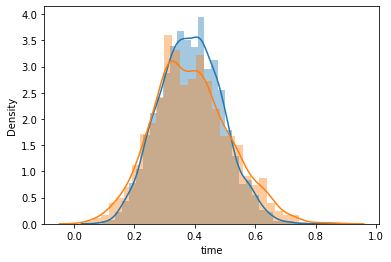

In [10]:
my_estimates_clustered = get_bootstrap_estimates(
    data=df, outcome=ols_fit, seeds=more_seeds, cluster_by="id"
)

# clustered distribution in blue
sns.distplot(my_estimates_clustered["time"])

# non-clustered distribution in orange
sns.distplot(my_estimates["time"])

We can also compute confidence intervals using estimates as an input.

In [11]:
from estimagic.inference.bootstrap_ci import compute_ci

confidence_intervals = compute_ci(
    data=df, outcome=ols_fit, estimates=my_estimates, ci_method="bc"
)

print(confidence_intervals)

           lower_ci   upper_ci
constant  91.256670  96.376470
time       0.202716   0.629642


Alternatively, we can compute the whole results table using specific estimates as an input.

In [12]:
from estimagic.inference.bootstrap import get_results_table

my_results = get_results_table(
    data=df, outcome=ols_fit, estimates=my_estimates, ci_method="t"
)

print(my_results)

               mean       std   lower_ci   upper_ci
constant  93.807724  1.551731  90.527128  96.689621
time       0.387905  0.127644   0.124907   0.618091


Finally, note that it is also possible to return the list of bootstrap samples using the get_bootstrap_samples() function. This function returns a list of ndraws np.arrays of bootstrap sample ids (row numbers) obtained from drawing from the original sample with replacement, using the cluster robust bootstrap if specified using the cluster_by input.
If we specify return_samples=True, the function instead returns a list of DataFrames. This can however be very memory inefficient for large datasets and/or large numbers of bootstrap draws.

In [14]:
from estimagic.inference.bootstrap_samples import get_bootstrap_samples

my_samples = get_bootstrap_samples(data=df, seeds=more_seeds)

print(type(my_samples))

print(my_samples[4])

<class 'list'>
[78 20 75 79 76 38 74 67 86 40 69 82 52 44 21 19  9 59 22 15 14 30 77 43
 64 23 35 40  9 22 70 55 28  3 47  9 29 18 55 36 45 20 29 41 79 69 11  9
 14 32 62 47 20  3 22 63 32 68 17 77 23 73 10 24 18 25  3 10 59 43 14  7
 11 87 78 60 25 51 82 47 88 29 77  1 76 47 22 72 55 41]
